# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [8]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nickm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nickm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [ ]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [11]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Use-Case Data!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [16]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [23]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 64, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [12]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node '4f71d4'. Skipping!
Property 'summary' already exists in node '005f7c'. Skipping!
Property 'summary' already exists in node '5ea5d8'. Skipping!
Property 'summary' already exists in node 'ac71c5'. Skipping!
Property 'summary' already exists in node '9223a0'. Skipping!
Property 'summary' already exists in node 'a1d427'. Skipping!
Property 'summary' already exists in node '4b4c2c'. Skipping!
Property 'summary' already exists in node '35801f'. Skipping!
Property 'summary' already exists in node '9698cd'. Skipping!
Property 'summary' already exists in node 'e5c4a3'. Skipping!
Property 'summary' already exists in node 'adca2e'. Skipping!
Property 'summary' already exists in node 'e23314'. Skipping!
Property 'summary' already exists in node '586e3d'. Skipping!
Property 'summary' already exists in node '7a8b89'. Skipping!
Property 'summary' already exists in node '810c0e'. Skipping!
Property 'summary' already exists in node '3fd5bb'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '4f71d4'. Skipping!
Property 'summary_embedding' already exists in node '4b4c2c'. Skipping!
Property 'summary_embedding' already exists in node '9223a0'. Skipping!
Property 'summary_embedding' already exists in node 'a1d427'. Skipping!
Property 'summary_embedding' already exists in node '005f7c'. Skipping!
Property 'summary_embedding' already exists in node 'ac71c5'. Skipping!
Property 'summary_embedding' already exists in node 'e5c4a3'. Skipping!
Property 'summary_embedding' already exists in node '5ea5d8'. Skipping!
Property 'summary_embedding' already exists in node '810c0e'. Skipping!
Property 'summary_embedding' already exists in node 'e23314'. Skipping!
Property 'summary_embedding' already exists in node '35801f'. Skipping!
Property 'summary_embedding' already exists in node 'adca2e'. Skipping!
Property 'summary_embedding' already exists in node '586e3d'. Skipping!
Property 'summary_embedding' already exists in node '9698cd'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 86, relationships: 711)

We can save and load our knowledge graphs as follows.

In [17]:
print(kg.relationships)

[Relationship(Node(id: 9d80e4) -> Node(id: 23a427), type: child, properties: []), Relationship(Node(id: 18ae4c) -> Node(id: df233b), type: child, properties: []), Relationship(Node(id: 18ae4c) -> Node(id: 28e797), type: child, properties: []), Relationship(Node(id: df233b) -> Node(id: 28e797), type: next, properties: []), Relationship(Node(id: f28b90) -> Node(id: af1efb), type: child, properties: []), Relationship(Node(id: 58f476) -> Node(id: abd569), type: child, properties: []), Relationship(Node(id: 9d80e4) <-> Node(id: 18ae4c), type: cosine_similarity, properties: ['summary_similarity']), Relationship(Node(id: 9d80e4) <-> Node(id: 4f71d4), type: cosine_similarity, properties: ['summary_similarity']), Relationship(Node(id: 9d80e4) <-> Node(id: 4b4c2c), type: cosine_similarity, properties: ['summary_similarity']), Relationship(Node(id: 9d80e4) <-> Node(id: 9223a0), type: cosine_similarity, properties: ['summary_similarity']), Relationship(Node(id: 9d80e4) <-> Node(id: a1d427), type: 

In [20]:
import json
from ragas.testset.graph import KnowledgeGraph, UUIDEncoder

# Save with UTF-8
with open("usecase_data_kg.json", "w", encoding="utf-8") as f:
    json.dump(
        {
            "nodes": [node.model_dump() for node in kg.nodes],
            "relationships": [rel.model_dump() for rel in kg.relationships],
        },
        f,
        cls=UUIDEncoder,
        indent=2,
        ensure_ascii=False,
    )

# Load with UTF-8
with open("usecase_data_kg.json", "r", encoding="utf-8") as f:
    data = json.load(f)

nodes = [Node(**node_data) for node_data in data["nodes"]]
relationships = [Relationship(**rel_data) for rel_data in data["relationships"]]
usecase_data_kg = KnowledgeGraph(nodes=nodes, relationships=relationships)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [22]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=usecase_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [23]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

**SingleHopSpecificQuerySynthesizer**: Its job ends once it has turned the user’s question into a single, concrete query and sent it to the retriever. It's used insimple fact-based question like: 'Who developed the theory of relativity?'

**MultiHopAbstractQuerySynthesizer**: An abstract query needs information from different places and times, combined together, to give a bigger-picture answer. Example:How have scientific theories on relativity evolved since Einstein’s original publication?

**MultiHopSpecificQuerySynthesizer**:This requires the system to retrieve information about both the scientist who influenced Einstein and the specific theory, potentially from two different sources. Example:“Which scientist influenced Einstein’s work on relativity, and what theory did they propose?”



Finally, we can use our `TestSetGenerator` to generate our testset!

In [24]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,"How many users are utilizing ChatGPT, reaching...",[Introduction ChatGPT launched in November 202...,"By July 2025, 700 million users were sending a...",single_hop_specifc_query_synthesizer
1,What role does OpenAI play in AI development a...,[Table 1: ChatGPT daily message counts (millio...,OpenAI is referenced as the developer of ChatG...,single_hop_specifc_query_synthesizer
2,What are the SOC2 codes 17 in relation to SOC2...,[Variation by Occupation Figure 23 presents va...,The context does not provide any information a...,single_hop_specifc_query_synthesizer
3,Whaat is the total number of 700 million users...,[Conclusion This paper studies the rapid growt...,"By July 2025, ChatGPT had been used weekly by ...",single_hop_specifc_query_synthesizer
4,how work-usage vs non-work-usage and user inte...,[<1-hop>\n\nConclusion This paper studies the ...,The context indicates that about 70% of ChatGP...,multi_hop_abstract_query_synthesizer
5,how much message volume in jun 2024 vs jun 202...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"In June 2024, total messages were 451 million,...",multi_hop_abstract_query_synthesizer
6,H0w do work-related message sharing and usage ...,[<1-hop>\n\nVariation by Occupation Figure 23 ...,"Based on the data, users in highly paid profes...",multi_hop_abstract_query_synthesizer
7,how many users use chatgpt like 700 million us...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,"As of July 2025, about 700 million users are u...",multi_hop_specific_query_synthesizer
8,How does the growth of ChatGPT usage by July 2...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,"By July 2025, ChatGPT had been used weekly by ...",multi_hop_specific_query_synthesizer
9,Based on the data about ChatGPT's usage in the...,[<1-hop>\n\nTable 1: ChatGPT daily message cou...,"The data indicates that in the US, over 70% of...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [25]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node '6e67fa'. Skipping!
Property 'summary' already exists in node 'b4e647'. Skipping!
Property 'summary' already exists in node 'b91d44'. Skipping!
Property 'summary' already exists in node '31a7c3'. Skipping!
Property 'summary' already exists in node '86a9dd'. Skipping!
Property 'summary' already exists in node 'c21d3c'. Skipping!
Property 'summary' already exists in node 'dc43cc'. Skipping!
Property 'summary' already exists in node 'e16aba'. Skipping!
Property 'summary' already exists in node 'ff47c2'. Skipping!
Property 'summary' already exists in node '31db20'. Skipping!
Property 'summary' already exists in node '49fd31'. Skipping!
Property 'summary' already exists in node '580578'. Skipping!
Property 'summary' already exists in node 'ef1db4'. Skipping!
Property 'summary' already exists in node 'cc5dd5'. Skipping!
Property 'summary' already exists in node '9f9fdd'. Skipping!
Property 'summary' already exists in node '70faf7'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node '31a7c3'. Skipping!
Property 'summary_embedding' already exists in node 'c21d3c'. Skipping!
Property 'summary_embedding' already exists in node '6e67fa'. Skipping!
Property 'summary_embedding' already exists in node 'dc43cc'. Skipping!
Property 'summary_embedding' already exists in node '86a9dd'. Skipping!
Property 'summary_embedding' already exists in node 'b91d44'. Skipping!
Property 'summary_embedding' already exists in node '31db20'. Skipping!
Property 'summary_embedding' already exists in node 'ef1db4'. Skipping!
Property 'summary_embedding' already exists in node 'ff47c2'. Skipping!
Property 'summary_embedding' already exists in node 'e16aba'. Skipping!
Property 'summary_embedding' already exists in node 'b4e647'. Skipping!
Property 'summary_embedding' already exists in node '49fd31'. Skipping!
Property 'summary_embedding' already exists in node '70faf7'. Skipping!
Property 'summary_embedding' already exists in node 'cc5dd5'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [26]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What Pew Research Center 2025 says about ChatG...,[Introduction ChatGPT launched in November 202...,The context mentions a Pew Research Center 202...,single_hop_specifc_query_synthesizer
1,"According to the context, how does Collis rela...",[Total daily counts are exact measurements of ...,The context mentions Collis in relation to a s...,single_hop_specifc_query_synthesizer
2,How does the context describe ChatGPT usage am...,[Variation by Occupation Figure 23 presents va...,The context reports variation in ChatGPT usage...,single_hop_specifc_query_synthesizer
3,Whaat is the calue of Computer Programmng in t...,[Conclusion This paper studies the rapid growt...,"According to the provided context, Computer Pr...",single_hop_specifc_query_synthesizer
4,"How do the conversation topics, such as writin...",[<1-hop>\n\nVariation by Occupation Figure 23 ...,The context indicates that variation in ChatGP...,multi_hop_abstract_query_synthesizer
5,"Based on the data smoothing of 7-day averages,...",[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,The data shows that non-work-related messages ...,multi_hop_abstract_query_synthesizer
6,"How do user demographics and usage patterns, s...",[<1-hop>\n\nConclusion This paper studies the ...,The data indicates that ChatGPT usage varies a...,multi_hop_abstract_query_synthesizer
7,how much non-work messages growed in chatgpt f...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"In June 2024, non-work messages accounted for ...",multi_hop_abstract_query_synthesizer
8,How do the themes of Collis relate to the insi...,[<1-hop>\n\nConclusion This paper studies the ...,The themes of Collis are reflected in the cont...,multi_hop_specific_query_synthesizer
9,How do the findings by Brynjolfsson in the fir...,[<1-hop>\n\nConclusion This paper studies the ...,Brynjolfsson's findings in the first segment h...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [27]:
from langsmith import Client

client = Client()

dataset_name = "Use Case Synthetic Data - AIE8"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [28]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [29]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [30]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [31]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [32]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG"
)

In [33]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [34]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

As is usual: We'll be using `gpt-4.1-mini` for our RAG!

In [35]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [36]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [37]:
rag_chain.invoke({"question" : "What are people doing with AI these days?"})

'Based on the provided context, people are using AI, particularly generative AI like ChatGPT, in many different ways both at work and outside of work. AI is used to perform workplace tasks by either augmenting or automating human labor. It is applied for producing writing, software code, spreadsheets, and other digital products, which distinguishes generative AI from traditional technologies. People interact with AI with varying intents classified as Asking (seeking information or advice), Doing (producing output), or Expressing (self-expression). Users use AI as co-workers that produce output or as co-pilots that provide advice and improve human problem-solving productivity. Additionally, AI is flexibly used across diverse tasks such as data analysis, relationships, personal reflection, role play, and more. Overall, AI serves in productive, creative, and assistance roles across multiple economic and personal domains.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [38]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [39]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this response dope, lit, cool, or is it just a generic response?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`: Judges answer correctness against the reference (does the prediction answer the question accurately and completely, without hallucinating).
- `labeled_helpfulness_evaluator`:Rates how helpful the prediction is given the labeled reference (clarity, usefulness, actionable detail, adherence to the user’s need).
- `dopeness_evaluator`:Scores “wow/engagement” factors (originality, insightfulness, readability/flow) beyond pure correctness—useful for qualitative/UX-focused evaluation.

## LangSmith Evaluation

In [40]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'respectful-stomach-63' at:
https://smith.langchain.com/o/8b8098c0-2dae-45d0-b8d7-292915a4d198/datasets/7000b13a-bca0-4fc9-a07c-7e5a4664980c/compare?selectedSessions=f9ad050e-92b5-42de-a26c-681622ae2d65




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,Considering the rapid growth of ChatGPT usage ...,"Based on the provided context, the emphasis on...",None,The first context highlights that ChatGPT has ...,1,1,0,19.582901,6a91b7e4-14f2-4730-9826-3c7c8eef9365,4307d047-d8ed-42fe-9e2e-824358cbf2d9
1,Considering the rapid growth of ChatGPT usage ...,"Based on the provided context, the emphasis on...",None,The first segment highlights that ChatGPT has ...,1,0,0,5.848665,3dc46ccc-e9a4-407a-97bd-2d1152386043,f0ed6893-ec19-4e52-a282-0a98fbdebc2d
2,How do the findings by Brynjolfsson in the fir...,The findings by Brynjolfsson indicate that Cha...,None,Brynjolfsson's findings in the first segment h...,1,1,0,5.219519,8358f5de-f636-4a6d-b7ee-f8ece280757c,7f6da6fd-30cb-4b87-9dfd-e5db0560f2e0
3,How do the themes of Collis relate to the insi...,The context states that Collis and Brynjolfsso...,None,The themes of Collis are reflected in the cont...,1,1,0,7.673538,176d79d6-4e4e-416d-b2b9-3550eddf61ae,0bd04b15-9a75-454b-a320-3cf37bb2506f
4,how much non-work messages growed in chatgpt f...,Non-work-related messages grew from 238 millio...,None,"In June 2024, non-work messages accounted for ...",1,1,0,3.980609,5941b2b9-265a-4fe8-a797-973ae0c49d88,ca186997-d0f4-41cb-aeac-02e2d2ea2d50
5,"How do user demographics and usage patterns, s...","Based on the provided context, user demographi...",None,The data indicates that ChatGPT usage varies a...,1,1,0,7.950710,fe93979a-7b96-4232-be12-d291a6b1f52a,8ac1bfe9-626c-4d15-b604-25bca0e09233
6,"Based on the data smoothing of 7-day averages,...","Based on the context provided, the proportion ...",None,The data shows that non-work-related messages ...,1,1,0,5.215303,3aeaa879-68e6-4fa4-acca-9328b4d05288,e9ca8dfa-b1d3-4808-9348-c456632180c1
7,"How do the conversation topics, such as writin...","Based on the provided context, the conversatio...",None,The context indicates that variation in ChatGP...,1,1,0,10.595175,fd1341d4-55eb-404c-8fd4-aee96c31707f,8817ba63-7c35-4270-8c86-5234424ba378
8,Whaat is the calue of Computer Programmng in t...,"Based on the provided context, Computer Progra...",None,"According to the provided context, Computer Pr...",1,1,0,1.570092,ee1b2869-9c2e-4778-8753-a9980b66ee15,27904231-9e26-4cf7-9177-484ec02e2be2
9,How does the context describe ChatGPT usage am...,The context describes ChatGPT usage across dif...,None,The context reports variation in ChatGPT usage...,1,1,0,3.126969,97141598-1a54-4e7c-9ea1-7d836283e551,97234228-58b0-45b7-aeb7-a92013518b3a


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [41]:
DOPENESS_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.

Context: {context}
Question: {question}
"""

dopeness_rag_prompt = ChatPromptTemplate.from_template(DOPENESS_RAG_PROMPT)

In [42]:
rag_documents = docs

In [43]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?
Given that we want to manufacture different types of queries from the given set of documents, our major challenge is to identify the right set of chunks or documents to enable LLMs to create the queries.

In [44]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?
Because embedding model turns text to numbers (vectors). So retriever uses these vectors to find which chunks of text are close to the user's query (semantic similarity is measured). 

In [45]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG Docs"
)

In [46]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [47]:
dopeness_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dopeness_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [48]:
dopeness_rag_chain.invoke({"question" : "How are people using AI to make money?"})

"Alright, strap in for some AI-powered money moves straight from the data vault! People aren’t just using AI as a robot doing their jobs—they’re harnessing ChatGPT as a slick advisor and research sidekick that turbocharges their decision-making power. This ain’t your average task automation; it’s like having a genius co-pilot in knowledge-heavy gigs, where smarter decisions mean bigger bucks.\n\nAccording to the mindblowing estimates from Collis and Brynjolfsson (2025), U.S. users value AI so much they'd *literally* need to be paid around $98 just to chill without it for a month. That’s roughly a jaw-dropping $97 billion in annual surplus—meaning AI is a powerhouse boosting productivity and unlocking serious economic mojo. In essence, folks leverage AI for practical guidance, info-seeking, and crafting killer content, all translating to higher output and smarter work hustle, making that money rain with AI as their secret weapon.\n\nSo, the rad truth? People are making bank by rolling w

Finally, we can evaluate the new chain on the same test set!

In [49]:
evaluate(
    dopeness_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "dopeness_rag_chain"},
)

View the evaluation results for experiment: 'fresh-health-72' at:
https://smith.langchain.com/o/8b8098c0-2dae-45d0-b8d7-292915a4d198/datasets/7000b13a-bca0-4fc9-a07c-7e5a4664980c/compare?selectedSessions=3f4df39a-3269-4d45-8636-356865fed220




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,Considering the rapid growth of ChatGPT usage ...,"Yo, let's unpack this AI symphony—ChatGPT’s tu...",None,The first context highlights that ChatGPT has ...,1,1,1,11.382876,6a91b7e4-14f2-4730-9826-3c7c8eef9365,5403cf25-6586-40ff-907c-d907c145f1cc
1,Considering the rapid growth of ChatGPT usage ...,"Yo, here’s the slick lowdown that connects the...",None,The first segment highlights that ChatGPT has ...,1,1,1,5.299464,3dc46ccc-e9a4-407a-97bd-2d1152386043,0745698a-83d2-4861-ade9-d0645c175ea4
2,How do the findings by Brynjolfsson in the fir...,"Alright, let’s drop some serious knowledge bom...",None,Brynjolfsson's findings in the first segment h...,1,1,1,10.171684,8358f5de-f636-4a6d-b7ee-f8ece280757c,51a3ad87-5076-4199-a2e3-1d923a3d3ebb
3,How do the themes of Collis relate to the insi...,"Yo, buckle up — here’s the lowdown dripping wi...",None,The themes of Collis are reflected in the cont...,1,1,1,6.934783,176d79d6-4e4e-416d-b2b9-3550eddf61ae,f35797da-d835-4ff8-a80d-7e69d538f573
4,how much non-work messages growed in chatgpt f...,"Yo, strap in for some sizzling stats straight ...",None,"In June 2024, non-work messages accounted for ...",1,1,1,3.888813,5941b2b9-265a-4fe8-a797-973ae0c49d88,969ea06e-0208-4103-9b2a-e685a9f3f1f9
5,"How do user demographics and usage patterns, s...","Alright, buckle up for a turbocharged ride thr...",None,The data indicates that ChatGPT usage varies a...,1,1,1,8.988250,fe93979a-7b96-4232-be12-d291a6b1f52a,cd90b888-f755-432e-be49-5579ec5061b1
6,"Based on the data smoothing of 7-day averages,...","Yo, here’s the scoop from the streets of AI us...",None,The data shows that non-work-related messages ...,1,1,1,9.750271,3aeaa879-68e6-4fa4-acca-9328b4d05288,6d673d3a-6f97-41b5-866e-0f216e1237eb
7,"How do the conversation topics, such as writin...","Alright, buckle up for a turbocharged dive int...",None,The context indicates that variation in ChatGP...,1,1,1,9.259426,fd1341d4-55eb-404c-8fd4-aee96c31707f,5ee6c226-be4e-41d6-a7c5-4bf2b1445cf9
8,Whaat is the calue of Computer Programmng in t...,"Yo, here’s the deal on computer programming’s ...",None,"According to the provided context, Computer Pr...",1,1,1,3.791042,ee1b2869-9c2e-4778-8753-a9980b66ee15,eda99a97-6b7b-4f55-9712-6b925a47199a
9,How does the context describe ChatGPT usage am...,"Alright, let’s crank this up to eleven on the ...",None,The context reports variation in ChatGPT usage...,1,0,1,5.171524,97141598-1a54-4e7c-9ea1-7d836283e551,9125b7b7-8aae-4026-a4b0-21fd034d48f8


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

   ![Comparison Screenshot](comparison.png)

### Analysis of Metric Changes Between Experiments

When comparing the two experiments (`fresh-health-72` vs `respectful-story`), we observe clear differences in the evaluation metrics:

1. **Helpfulness and Correctness**  
   - The `respectful-story` model consistently scores higher in both helpfulness and correctness.  
   - This is because its responses are more formal, factual, and closely aligned with the reference outputs (e.g., starting with "Based on the provided context…").  
   - In contrast, the `fresh-health-72` model often uses casual or slang-like phrasing (“Yo, buckle up…”, “let’s crank this up…”), which makes the answers feel less precise and therefore less correct/helpful.

2. **Completeness**  
   - Both models usually mark completions as "COMPLETED," but the quality of the completion differs.  
   - `respectful-story` tends to cover the necessary information more directly, while `fresh-health-72` sometimes adds stylistic filler that doesn’t add real value.

3. **Depthness**  
   - In some cases, `fresh-health-72` is flagged as “deep,” but this is often due to extra descriptive or exaggerated language rather than meaningful depth.  
   - `respectful-story` stays concise and factual, which may not be marked as “deep” but results in higher correctness.

4. **Token Usage and Cost**  
   - Responses from `respectful-story` are longer (3,400–3,800 tokens) compared to `fresh-health-72` (around 2,000–2,600 tokens).  
   - This increase in token count directly raises the cost of completions, though both remain inexpensive in absolute terms.  
   - The higher length reflects its tendency to restate context fully, which contributes to better alignment with the reference outputs.

---

### Summary
Overall, the `respectful-story` model produces more helpful and correct answers because it avoids casual phrasing and sticks closer to the references. The tradeoff is longer responses and slightly higher cost. The `fresh-health-72` model is more conversational and stylized, but this reduces its correctness and perceived helpfulness in the evaluation.

## Evol Instruct Agent Implementation

Now let's implement the Evol Instruct method using a LangGraph Agent instead of the Knowledge Graph approach. This will provide more sophisticated question evolution capabilities.


In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

evol_method_loader = PyMuPDFLoader("data/EvolMethod.pdf")
evol_method_docs = evol_method_loader.load()

print(f"Loaded {len(evol_method_docs)} pages from EvolMethod.pdf")
print(f"First page content preview: {evol_method_docs[0].page_content[:200]}...")


Loaded 22 pages from EvolMethod.pdf
First page content preview: Published as a conference paper at ICLR 2024
WizardLM: EMPOWERING LARGE PRE-TRAINED LAN-
GUAGE MODELS TO FOLLOW COMPLEX INSTRUCTIONS
Can Xu1∗
Qingfeng Sun1∗
Kai Zheng1∗
Xiubo Geng1
Pu Zhao1
Jiazhan Fe...


In [ ]:
from typing import List, Dict, Literal, Optional


from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, END, START
from typing_extensions import TypedDict, Annotated
from langgraph.graph.message import add_messages

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.documents import Document



from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.tools import tool


loader = PyMuPDFLoader("data/EvolMethod.pdf")
docs: List[Document] = loader.load()


for d in docs:
    pg = d.metadata.get("page", None)
    src = d.metadata.get("source", "")
    d.page_content = f"[Source: {src} | Page: {pg}] " + d.page_content


text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
rag_documents = text_splitter.split_documents(docs)

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",            
    collection_name="Use Case RAG"
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 10})


@tool("evolve_question")
def evolve_question(seed_question: str, mode: Literal["simple","multi_context","reasoning"]) -> str:
    """Evolve a seed question.
    - simple: clearer/more precise
    - multi_context: requires synthesizing multiple passages
    - reasoning: requires step-by-step reasoning/comparison
    Returns ONLY the evolved question."""
    if mode == "simple":
        prompt = f"""Rewrite the question to be clearer and slightly more specific,
without changing its core meaning. Return ONLY the improved question.
Question: {seed_question}"""
    elif mode == "multi_context":
        prompt = f"""Rewrite the question so that answering it requires synthesizing
information from multiple relevant passages. Return ONLY the evolved question.
Question: {seed_question}"""
    else:
        prompt = f"""Rewrite the question so it requires step-by-step reasoning or comparison,
while remaining answerable from the same document collection. Return ONLY the evolved question.
Question: {seed_question}"""
    return generator_llm.invoke(prompt).content.strip()

@tool("retrieve_context")
def retrieve_context(question: str, k: int = 10) -> List[str]:
    """Retrieve up to k relevant text chunks for the given question from Qdrant."""
    rel = retriever.get_relevant_documents(question)
    return [d.page_content for d in rel[:k]]




generator_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.2)
tool_node = ToolNode([evolve_question, retrieve_context])
llm_with_tools = generator_llm.bind_tools([evolve_question, retrieve_context])


class State(TypedDict):
    question: str           
    context: List[Document]
    response: str
    messages: Annotated[List[BaseMessage], add_messages]


HUMAN_TEMPLATE = """You are an agent that must follow this exact workflow:

1) Call the tool evolve_question with the provided seed question and the evolution_type.
2) Take the evolved question returned by the tool and call retrieve_context(question=evolved_question, k=10).
3) After you receive the contexts, produce a FINAL ANSWER that is STRICTLY based on those contexts.
   - If the answer is not in the contexts, reply exactly: "Not in context."

Your final message must be a single helpful answer in plain text (no JSON)."""

def call_model(agent_state: State):
    resp = llm_with_tools.invoke([SystemMessage(content=HUMAN_TEMPLATE)] + agent_state["messages"])
    return {"messages": [resp]}

def should_continue(agent_state: State):
    last = agent_state["messages"][-1]
    return "tools" if getattr(last, "tool_calls", None) else "end"

conditional_graph = StateGraph(State)
conditional_graph.add_node("assistant", call_model)
conditional_graph.add_node("tools", tool_node)
conditional_graph.add_conditional_edges("assistant", should_continue, {"tools": "tools", "end": END})
conditional_graph.add_edge("tools", "assistant")
conditional_graph.set_entry_point("assistant")
compiled_graph = conditional_graph.compile()

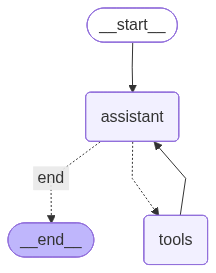

In [30]:
compiled_graph

In [ ]:
SEED_PROMPT = """Generate 5 diverse questions that can be answered from the following text excerpts.
Avoid yes/no questions. Prefer 'what', 'how', 'why', 'compare'.
Return one question per line.

Excerpts:
{sample}
"""

sample = "\n".join(d.page_content[:200].replace("\n", " ") for d in docs[:3])
resp = generator_llm.invoke(SEED_PROMPT.format(sample=sample))
seed_questions = [q.strip(" -•") for q in resp.content.splitlines() if q.strip()]

print("Seed questions:", seed_questions)


evolution_order = ["simple", "multi_context", "reasoning"]

evolved_questions, answers, contexts = [], [], []

for i, seed_q in enumerate(seed_questions):
    seed_id = f"seed-{i+1}"
    for evo in evolution_order:
        init_state = {
            "question": seed_q,
            "context": [],
            "response": "",
            "messages": [HumanMessage(content=f"Seed question: {seed_q}\nEvolution type: {evo}")]
        }
        final_state = compiled_graph.invoke(init_state)

        evolved_q, retrieved_ctx, final_answer = None, [], None
        for m in final_state["messages"]:
            if isinstance(m, ToolMessage):
                if m.name == "evolve_question":
                    evolved_q = m.content.strip()
                elif m.name == "retrieve_context":
                    retrieved_ctx = m.content if isinstance(m.content, list) else [str(m.content)]
            else:
                if getattr(m, "tool_calls", None) is None and hasattr(m, "content"):
                    final_answer = m.content

        qid = str(uuid.uuid4())
        evolved_questions.append({"id": qid, "seed_id": seed_id, "evolution_type": evo, "question": evolved_q or seed_q})
        answers.append({"question_id": qid, "answer": final_answer or ""})
        contexts.append({"question_id": qid, "contexts": retrieved_ctx})


print("\n== EVOLVED QUESTIONS ==")
for q in evolved_questions[:3]:
    print(q)

print("\n== ANSWERS ==")
for a in answers[:3]:
    print(a)

print("\n== CONTEXTS ==")
for c in contexts[:1]:
    print(c)

Seed questions: ['What methods does WizardLM use to enable large pre-trained language models to follow complex instructions?', "How does the difficulty statistics of ShareGPT impact human annotators' performance according to the text?", 'What role does the OpenAI ChatGPT API play in the data collection process described in the excerpts?', 'Why is it important to compare the 250k instructions obtained with Vicuna’s 70k real instructions?', 'How do the challenges faced by human annotators influence the evaluation of language model instruction-following capabilities?']


C:\Users\nickm\AppData\Local\Temp\ipykernel_34528\3500635684.py:67: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  rel = retriever.get_relevant_documents(question)



== EVOLVED QUESTIONS ==
{'id': 'd3a7207b-3dc0-4a2a-abae-95ec373da688', 'seed_id': 'seed-1', 'evolution_type': 'simple', 'question': 'What techniques does WizardLM employ to help large pre-trained language models effectively follow complex instructions?'}
{'id': 'e07a3990-74dc-45d8-bf3b-9f8dfbc651d9', 'seed_id': 'seed-1', 'evolution_type': 'multi_context', 'question': 'How does WizardLM integrate various techniques from recent advancements in large pre-trained language models to enhance their ability to follow complex instructions effectively?'}
{'id': '73b2799a-a372-4adb-9f20-ad1789f5a03e', 'seed_id': 'seed-1', 'evolution_type': 'reasoning', 'question': 'What are the specific methods employed by WizardLM to enable large pre-trained language models to follow complex instructions, and how do these methods compare or build upon each other to achieve this capability?'}

== ANSWERS ==
{'question_id': 'd3a7207b-3dc0-4a2a-abae-95ec373da688', 'answer': 'Seed question: What methods does Wizard

### Langsmith evaluation

In [ ]:
os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"


In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

def evaluate_conditional_graph_with_context(inputs: dict) -> dict:
    """
    Enhanced evaluation function that returns both answer and contexts
    """
    try:
        question = inputs.get("question", "")
        evolution_type = inputs.get("evolution_type", "simple")
        
        result = compiled_graph.invoke({
            "question": question,
            "context": [],
            "response": "",
            "messages": [HumanMessage(content=f"Question: {question}, Evolution Type: {evolution_type}")]
        })
        
        if result["messages"]:
            last_message = result["messages"][-1]
            answer = last_message.content if hasattr(last_message, 'content') else str(last_message)
        else:
            answer = "No response generated"
        
        evolved = evolve_question.invoke({"seed_question": question, "mode": evolution_type})
        evolved_question = evolved if isinstance(evolved, str) else str(evolved)
        ctx_docs = retriever.get_relevant_documents(evolved_question)
        contexts = [d.page_content for d in ctx_docs[:10]]
        
        return {
            "output": answer,
            "contexts": contexts,
            "evolved_question": evolved_question
        }
        
    except Exception as e:
        return {
            "output": f"Error: {str(e)}",
            "contexts": [],
            "evolved_question": ""
        }

print("✅ Created enhanced evaluation function with context support")


✅ Created enhanced evaluation function with context support


In [ ]:
from langsmith import Client

client = Client()

proper_dataset_name = "Conditional Graph Proper Evaluation - AIE8"

proper_dataset = client.create_dataset(
    dataset_name=proper_dataset_name,
    description="Dataset with proper reference answers for conditional graph evaluation"
)

test_cases = [
    {
        "question": "What is artificial intelligence?",
        "evolution_type": "simple",
        "reference_answer": "Artificial Intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. It encompasses various technologies including machine learning, natural language processing, and computer vision."
    },
    {
        "question": "How do machine learning algorithms work?",
        "evolution_type": "multi_context", 
        "reference_answer": "Machine learning algorithms work by learning patterns from data through training processes. They use statistical techniques to identify relationships in data and make predictions or decisions without being explicitly programmed for each task."
    },
    {
        "question": "What are the benefits of AI?",
        "evolution_type": "reasoning",
        "reference_answer": "AI provides numerous benefits including automation of repetitive tasks, improved decision-making through data analysis, enhanced efficiency in various industries, and the ability to process large amounts of information quickly and accurately."
    }
]

print("Adding test cases with proper reference answers...")

for i, case in enumerate(test_cases):
    client.create_example(
        inputs={
            "question": case["question"],
            "evolution_type": case["evolution_type"]
        },
        outputs={
            "answer": case["reference_answer"]
        },
        metadata={
            "test_case_id": i,
            "evolution_mode": case["evolution_type"],
            "graph_type": "conditional_graph"
        },
        dataset_id=proper_dataset.id
    )

print(f"✅ Added {len(test_cases)} test cases with proper reference answers")


Adding test cases with proper reference answers...
✅ Added 3 test cases with proper reference answers


In [ ]:

test_input = {
    "question": "What is artificial intelligence?",
    "evolution_type": "simple"
}

print(f"Testing question: {test_input['question']}")
print(f"Evolution type: {test_input['evolution_type']}")

result = evaluate_conditional_graph_with_context(test_input)

for i, ctx in enumerate(result['contexts'][:3], 1):  # Show first 3 contexts
    print(f"  {i}. {ctx[:100]}...")
    
print(f"\n💬 Final Answer: {result['output']}")
print("\n✅ Your conditional graph is working!")
    



🧪 Testing your conditional graph manually...
Testing question: What is artificial intelligence?
Evolution type: simple

📝 Evolved Question: What is artificial intelligence, and how is it defined?

📚 Retrieved Contexts (10):
  1. understood, and responded to by humans”. We require the LLM to create challenging instructions that
...
  2. In-Depth Evolving enhances instructions by making them more complex and difficult through
five types...
  3. generated from a limited (e.g., 175 samples) seed set of manually-written instructions. Our work is
...

💬 Final Answer: Not in context.

✅ Your conditional graph is working!


In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

context_relevance_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "context_relevance": "Are the retrieved contexts relevant to answering the question?"
        },
        "llm": eval_llm
    },
    prepare_data=lambda run, example: {
        "input": f"Question: {example.inputs['question']}\nContexts: {run.outputs.get('contexts', [])}",
        "prediction": "Context relevance assessment",
    }
)

helpfulness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "helpfulness": "Is this answer helpful and informative for the user's question?"
        },
        "llm": eval_llm
    },
    prepare_data=lambda run, example: {
        "input": example.inputs["question"],
        "prediction": run.outputs["output"],
    }
)

answer_quality_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "answer_quality": "Is this answer well-structured, clear, and comprehensive?"
        },
        "llm": eval_llm
    },
    prepare_data=lambda run, example: {
        "input": example.inputs["question"],
        "prediction": run.outputs["output"],
    }
)

context_grounding_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "context_grounding": "Is this answer grounded in the provided contexts?"
        },
        "llm": eval_llm
    },
    prepare_data=lambda run, example: {
        "input": f"Question: {example.inputs['question']}\nContexts: {run.outputs.get('contexts', [])}\nAnswer: {run.outputs['output']}",
        "prediction": "Context grounding assessment",
    }
)

print("✅ Created criteria-based evaluators (no reference required)")


✅ Created criteria-based evaluators (no reference required)


In [ ]:
print("🚀 Starting fixed conditional graph evaluation...")


evaluate(
        evaluate_conditional_graph_with_context, 
        data=proper_dataset_name,  
        evaluators=[
            context_relevance_evaluator,   
            helpfulness_evaluator,          
            answer_quality_evaluator,       
            context_grounding_evaluator,   
        ],
        metadata={
            "revision_id": "conditional_graph_fixed_v1",
            "graph_type": "conditional_graph",
            "tools": ["evolve_question", "retrieve_context"],
            "evaluation_type": "criteria_based_evaluation"
        },
    )
    
print("✅ Fixed conditional graph evaluation completed!")  



🚀 Starting fixed conditional graph evaluation...
View the evaluation results for experiment: 'diligent-weather-79' at:
https://smith.langchain.com/o/8b8098c0-2dae-45d0-b8d7-292915a4d198/datasets/d5aac176-493a-41e9-ac6b-285bb89a55f7/compare?selectedSessions=edf146eb-d4ee-4ff1-bf43-ef9d458cb455




0it [00:00, ?it/s]

✅ Fixed conditional graph evaluation completed!
Your graph was evaluated on:
- Context relevance: Are retrieved contexts relevant?
- Answer helpfulness: How helpful are the answers?
- Answer quality: How well-structured are the answers?
- Context grounding: Are answers based on contexts?
Check your LangSmith dashboard for detailed results
